# Import

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display ,HTML
import requests, os
from PIL import Image
from io import BytesIO
from pyzbar.pyzbar import decode
from tqdm.auto import tqdm
from pathlib import Path

# Raw data

## Read raw data file

In [2]:
b_file_path = 'raw_data_production/b_file.csv'
b_iblock_element_path = 'raw_data_production/b_iblock_element.csv'
b_iblock_element_property_path = 'raw_data_production/b_iblock_element_property.csv'
b_iblock_property_path = 'raw_data_production/b_iblock_property.csv'
b_iblock_section_element_path = 'raw_data_production/b_iblock_section_element.csv'
b_iblock_section_path = 'raw_data_production/b_iblock_section.csv'
b_iblock_path = 'raw_data_production/b_iblock.csv'

b_iblock_element_property = pd.read_csv(b_iblock_element_property_path, usecols=['ID', 'IBLOCK_PROPERTY_ID', 'IBLOCK_ELEMENT_ID', 'VALUE'])
b_file = pd.read_csv(b_file_path, usecols=['ID', 'SUBDIR', 'FILE_NAME', 'ORIGINAL_NAME'])
b_iblock_element = pd.read_csv(b_iblock_element_path, usecols=['ID', 'IBLOCK_ID', 'IBLOCK_SECTION_ID', 'ACTIVE', 'NAME', 'PREVIEW_PICTURE', 'TIMESTAMP_X'])
b_iblock_property = pd.read_csv(b_iblock_property_path, usecols=['ID', 'IBLOCK_ID', 'NAME', 'ACTIVE'])
b_iblock_section_element = pd.read_csv(b_iblock_section_element_path, usecols=['IBLOCK_SECTION_ID', 'IBLOCK_ELEMENT_ID'])
b_iblock_section = pd.read_csv(b_iblock_section_path, usecols=['ID', 'IBLOCK_ID', 'IBLOCK_SECTION_ID', 'NAME', 'ACTIVE', 'DEPTH_LEVEL', 'TIMESTAMP_X'])
b_iblock = pd.read_csv(b_iblock_path, usecols=['ID', 'IBLOCK_TYPE_ID', 'NAME'])

## Query data

In [3]:
url_404 = 'https://viterbischool.usc.edu/wp-content/uploads/2023/10/404.jpg'
oops_url = 'https://colorlib.com/wp/wp-content/uploads/sites/2/404-error-page-templates.jpg'
cosmenet_upload_url_prefix = 'https://www.cosmenet.in.th/upload/'
product_url_prefix = 'https://www.cosmenet.in.th/product/'

### Show info

In [4]:
b_iblock_product = b_iblock[b_iblock['IBLOCK_TYPE_ID'] == 'product']

In [5]:
b_iblock_product_html = f"<h3>b_iblock_product</h3>\n{b_iblock_product.to_html(index=False)}"
b_iblock_section_html = f"<h3>b_iblock_section</h3>\n{b_iblock_section.head().to_html(index=False)}"
b_iblock_element_html = f"<h3>b_iblock_element</h3>\n{b_iblock_element.head().to_html(index=False)}"
b_iblock_element_property_html = f"<h3>b_iblock_element_property</h3>\n{b_iblock_element_property.head().to_html(index=False)}"
b_file_html = f"<h3>b_file</h3>\n{b_file.head().to_html(index=False)}"
b_iblock_property_html = f"<h3>b_iblock_property</h3>\n{b_iblock_property.head().to_html(index=False)}"
b_iblock_section_element_html = f"<h3>b_iblock_section_element</h3>\n{b_iblock_section_element.head().to_html(index=False)}"

# Combine HTML for side-by-side display
html_combined = f"<div style='display: inline-block; margin-right: 20px;'>{b_iblock_product_html}</div>" \
                f"<div style='display: inline-block; margin-right: 20px;'>{b_iblock_property_html}</div>" \
                f"<div style='display: inline-block;'>{b_file_html}</div>" \
                f"<div style='display: inline-block;'>{b_iblock_element_html}</div>" \
                f"<div style='display: inline-block; margin-right: 20px;'>{b_iblock_element_property_html}</div>" \
                f"<div style='display: inline-block; margin-right: 20px;'>{b_iblock_section_html}</div>" \
                f"<div style='display: inline-block;'>{b_iblock_section_element_html}</div>" \

# Display the HTML
display(HTML(html_combined))

### Brand

In [6]:
b_iblock[b_iblock['ID'] == 17]

,ID,IBLOCK_TYPE_ID,NAME
7,17,product,Maker


In [4]:
# Filter only brand and drop maker
brand_and_maker_iblock_index = b_iblock_section['IBLOCK_ID'] == 17
brand_depth_index = b_iblock_section['DEPTH_LEVEL'] == 2
brand_data = b_iblock_section[brand_and_maker_iblock_index & brand_depth_index]
brand_data = brand_data.drop(columns=['IBLOCK_ID', 'DEPTH_LEVEL'])
brand_data.rename(columns={'ID': 'BID', 'NAME': 'BRAND_NAME', 'IBLOCK_SECTION_ID':'MID'}, inplace=True)
brand_data = brand_data.astype({'MID': 'int32'})
# Check for duplicate brand name
brand_duplicate_unique = brand_data[brand_data['BRAND_NAME'].duplicated()].sort_values(by='BRAND_NAME')['BRAND_NAME'].unique()
brand_duplicate = brand_data[brand_data['BRAND_NAME'].isin(brand_duplicate_unique)]\
    .sort_values(['BRAND_NAME', 'BID'])[['BID', 'BRAND_NAME']]
# brand not active
brand_not_active_index = brand_data['ACTIVE'] == 'N'
brand_not_active_data = brand_data[brand_not_active_index]
brand_not_active_data = brand_not_active_data.drop(columns=['ACTIVE'])
# brand active
brand_active_index = brand_data['ACTIVE'] == 'Y'
brand_active_data = brand_data[brand_active_index]
brand_active_data = brand_active_data.drop(columns=['ACTIVE'])

brand_data.reset_index(drop=True, inplace=True)
brand_data.head(1)

,BID,TIMESTAMP_X,MID,ACTIVE,BRAND_NAME
0,1268,2017-07-13 15:30:48,1123,N,SHISEIDO (Pureness)


In [5]:
brand_duplicate_unique

array([], dtype=object)

In [6]:
brand_duplicate

,BID,BRAND_NAME


#### Save data

In [22]:
brand_data.drop(columns=['MID']).to_csv('data_production/brand.csv', index=False)

### Category & Subcategory

In [16]:
b_iblock[b_iblock['ID'] == 6]

,ID,IBLOCK_TYPE_ID,NAME
0,6,product,Item_category


In [5]:
# Filter only category and subcategory
cat_and_subcat_block_index = b_iblock_section['IBLOCK_ID'] == 6
cat_subcat_data = b_iblock_section[cat_and_subcat_block_index]
cat_subcat_data = cat_subcat_data.drop(columns=['IBLOCK_ID'])
# not active
cat_subcat_not_active_index = cat_subcat_data['ACTIVE'] == 'N'
cat_subcat_not_active_data = cat_subcat_data[cat_subcat_not_active_index]
cat_subcat_not_active_data = cat_subcat_not_active_data.drop(columns=['ACTIVE'])
# active
cat_subcat_active_index = cat_subcat_data['ACTIVE'] == 'Y'
cat_subcat_active_data = cat_subcat_data[cat_subcat_active_index]
cat_subcat_active_data = cat_subcat_active_data.drop(columns=['ACTIVE'])

In [8]:
cat_subcat_not_active_data

,ID,TIMESTAMP_X,IBLOCK_SECTION_ID,NAME,DEPTH_LEVEL


Category

In [6]:
# Filter only category and drop subcategory
category_data = cat_subcat_data[cat_subcat_data['DEPTH_LEVEL'] == 1]
category_data = category_data.drop(columns=['DEPTH_LEVEL', 'IBLOCK_SECTION_ID'])
category_data.rename(columns={'ID': 'CID', 'NAME': 'CATEGORY_NAME'}, inplace=True)
category_data.reset_index(drop=True, inplace=True)
category_data.head(1)

,CID,TIMESTAMP_X,ACTIVE,CATEGORY_NAME
0,53,2018-11-16 13:32:35,Y,Skincare


Subcategory

In [7]:
# Merge category and subcategory
subcategory_data = pd.merge(cat_subcat_data, cat_subcat_data, left_on='IBLOCK_SECTION_ID', right_on='ID')
midcategory_index = subcategory_data['DEPTH_LEVEL_x'] == 2
subcategory_data = subcategory_data[~midcategory_index]
subcategory_data.drop(columns=['DEPTH_LEVEL_x', 'DEPTH_LEVEL_y', 'ID_y', 'NAME_y', 'IBLOCK_SECTION_ID_x', 'TIMESTAMP_X_y', 'ACTIVE_y'], inplace=True)
subcategory_data.rename(columns={'ID_x': 'SCID', 'NAME_x': 'SUBCATEGORY_NAME', 'IBLOCK_SECTION_ID_y': 'CID', 
                                 'TIMESTAMP_X_x':'TIMESTAMP_X', 'ACTIVE_x':'ACTIVE'}, inplace=True)
subcategory_data = subcategory_data.astype({'CID': 'int32'})
subcategory_data.reset_index(drop=True, inplace=True)
subcategory_data.head(1)

,SCID,TIMESTAMP_X,ACTIVE,SUBCATEGORY_NAME,CID
0,56,2022-11-16 09:49:32,Y,Facial Foam,53


#### Save data

In [26]:
category_data.to_csv('data_production/category.csv', index=False)
subcategory_data.to_csv('data_production/subcategory.csv', index=False)

### Product

In [10]:
# Filter only product
product_block_index = b_iblock_element['IBLOCK_ID'] == 17
product_data = b_iblock_element[product_block_index]
product_data = product_data.drop(columns=['IBLOCK_ID'])
product_data.rename(columns={'ID': 'EID', 'IBLOCK_SECTION_ID': 'BID', 'NAME': 'PRODUCT_NAME'}, inplace=True)
# Check brand not provided
product_not_BID = product_data[product_data['BID'].isna()]
product_data = product_data.astype({'BID': 'int32'})
# create product url
product_data['PRODUCT_URL'] = product_data['EID'].apply(lambda x: product_url_prefix + str(x))
# merge product with category and subcategory
subcat_link_data = pd.merge(b_iblock_section_element, subcategory_data.drop(columns=['ACTIVE']), how='right', left_on='IBLOCK_SECTION_ID', right_on='SCID')
subcat_link_data.drop(columns=['IBLOCK_SECTION_ID', 'SUBCATEGORY_NAME', 'CID', 'TIMESTAMP_X'], inplace=True)
product_data_linked= pd.merge(product_data, subcat_link_data, how='left', left_on='EID', right_on='IBLOCK_ELEMENT_ID')
product_data_linked.drop(columns=['IBLOCK_ELEMENT_ID'], inplace=True)
# create product preview image
product_data_linked = pd.merge(product_data_linked, b_file, left_on='PREVIEW_PICTURE', right_on='ID', how='left')

product_data_linked['PREVIEW_PICTURE'] = product_data_linked.apply(lambda x: cosmenet_upload_url_prefix + x['SUBDIR'] 
                                                                   if not pd.isna(x['PREVIEW_PICTURE']) 
                                                                   else oops_url, axis=1)
def check_url(x):
    if not pd.isna(x['FILE_NAME']):
        return x['PREVIEW_PICTURE'] + '/' + x['FILE_NAME']
    elif x['PREVIEW_PICTURE'] == oops_url:
        return x['PREVIEW_PICTURE']
    else:
        return url_404
product_data_linked['PREVIEW_PICTURE'] = product_data_linked.apply(lambda x: check_url(x), axis=1)
product_data_linked.drop(columns=['ID', 'SUBDIR', 'ORIGINAL_NAME'], inplace=True)
# active
product_active_index = product_data_linked['ACTIVE'] == 'Y'
product_active_data = product_data_linked[product_active_index]
product_active_data = product_active_data.drop(columns=['ACTIVE'])
product_active_data = product_active_data.astype({'SCID': 'int32'})
# not active
product_not_active_index = product_data_linked['ACTIVE'] == 'N'
product_not_active_data = product_data_linked[product_not_active_index]
product_not_active_data = product_not_active_data.drop(columns=['ACTIVE'])

product_data_linked.reset_index(drop=True, inplace=True)
product_data_linked.head(1)

,EID,TIMESTAMP_X,BID,ACTIVE,PRODUCT_NAME,PREVIEW_PICTURE,PRODUCT_URL,SCID,FILE_NAME
0,102,2022-06-28 20:09:51,1497,Y,Beneficial Make Off Perfect Eye & Lip Makeup R...,https://www.cosmenet.in.th/upload/iblock/b09/B...,https://www.cosmenet.in.th/product/102,73.0,Beneficial-Make-Off-Perfect-Eye-Lip-Makeup-Rem...


In [12]:
product_not_BID

,EID,BID,ACTIVE,PRODUCT_NAME,PREVIEW_PICTURE


#### Save data

In [19]:
product_data_linked.to_csv('data_production/product.csv', index=False)

### Barcode

In [191]:
def clean_code(x):
    x = x.replace(' ', '')
    try:
        x = int(x)
    except:
        pass
    return str(x)

In [192]:
# filter only code
code_barcode_img_index = b_iblock_element_property['IBLOCK_PROPERTY_ID'] == 246
code_barcode_img_data = b_iblock_element_property[code_barcode_img_index]
code_barcode_img_data.loc[:, 'VALUE'] = code_barcode_img_data['VALUE'].apply(clean_code)
code_barcode_img_data = code_barcode_img_data.drop(columns=['IBLOCK_PROPERTY_ID', 'ID'])
code_barcode_img_data.rename(columns={'IBLOCK_ELEMENT_ID': 'EID', 'VALUE': 'CODE'}, inplace=True)
# check duplicate code
code_duplicate = code_barcode_img_data[code_barcode_img_data.duplicated(subset=['CODE','EID'], keep=False)]

code_barcode_img_data.reset_index(drop=True, inplace=True)
code_barcode_img_data.head(1)

,EID,CODE
0,43278,8809057514940


In [62]:
# Filter only barcode
barcode_img_index = b_iblock_element_property['IBLOCK_PROPERTY_ID'] == 247
barcode_img_data = b_iblock_element_property[barcode_img_index]
barcode_img_data = barcode_img_data.drop(columns=['IBLOCK_PROPERTY_ID', 'ID'])
barcode_img_data = barcode_img_data.astype({'VALUE': 'int64'})
# join image path
barcode_img_data = pd.merge(barcode_img_data, b_file, how='left', left_on='VALUE', right_on='ID')
barcode_img_data.drop(barcode_img_data[barcode_img_data['ID'].isna()].index, inplace=True)
# create barcode image path
barcode_img_data['BARCODE_PATH'] = barcode_img_data.apply(lambda x: cosmenet_upload_url_prefix + x['SUBDIR'] + '/' + x['FILE_NAME'], axis=1)
barcode_img_data.drop(columns=['ID', 'ORIGINAL_NAME', 'SUBDIR', 'FILE_NAME', 'VALUE'], inplace=True)
barcode_img_data.rename(columns={'IBLOCK_ELEMENT_ID': 'EID'}, inplace=True)

barcode_img_data.reset_index(drop=True, inplace=True)
barcode_img_data.head(1)

,EID,BARCODE_PATH
0,43278,https://www.cosmenet.in.th/upload/iblock/57a/S...


In [18]:
def cvt_transparency(img:Image.Image):
    new_image = Image.new("RGBA", img.size, "WHITE") # Create a white rgba background
    new_image.paste(img, (0, 0), img)              # Paste the image on the background. Go to the links given below for details.
    return new_image

def resize_img_scale(img:Image.Image, scale=2):
    w, h = img.size
    return img.resize((w*scale, h*scale))

def read_image_from_url(barcode_url:str):
    img = Image.open(BytesIO(requests.get(barcode_url).content))
    if img.has_transparency_data:
        img = cvt_transparency(img)
        
def decode_barcode(img:Image.Image):
    decodedObjects = decode(img)
    for scale in range(2, 7):
        if len(decodedObjects) == 0 or len(decodedObjects) > 1:
            decodedObjects = decode(resize_img_scale(img, scale))
        else:
            break
    return decodedObjects

In [44]:
def decode_barcode_from_url(barcode_url, eid):
    try:
        img = read_image_from_url(barcode_url)
    except:
        print(f'{eid} Bad url: {barcode_url}')
        return None
    try: 
        decodedObjects = decode_barcode(img)
    except:
        print(f'{eid} Bad image: {barcode_url}')
        return None
    if decodedObjects == []:
        print(f'{eid} Not barcode: {barcode_url}')
        return None
    elif len(decodedObjects) > 1:
        print(f'{eid} More than 1 barcode: {barcode_url} , result : {decodedObjects}')
        return None
    result = decodedObjects[0].data.decode('utf-8')
    try:
        result = int(result)
    except:
        print(f'{eid} Not number: {barcode_url} , result : {result}')
    return str(result)

In [64]:
tqdm.pandas(desc="my bar!")
# decode barcode
barcode_img_data.loc[:, 'CODE'] = barcode_img_data.progress_apply(lambda x: decode_barcode_from_url(x['BARCODE_PATH'], x['EID']), axis=1)
barcode_img_data.drop(barcode_img_data[barcode_img_data['CODE'].isna()].index, inplace=True)
barcode_img_data.reset_index(drop=True, inplace=True)
barcode_img_data.head(1)

my bar!:   0%|          | 0/337 [00:00<?, ?it/s]

50600 Bad url: https://www.cosmenet.in.th/upload/iblock/a78/ภาพหน้าจอ 2566-09-30 เวลา 02.55.03.png
50295 Not number: https://www.cosmenet.in.th/upload/iblock/597/E65264E0-3F5D-4E0C-9FD2-187220CDC7B6.jpg , result : 125896TH


,EID,BARCODE_PATH,CODE
0,43278,https://www.cosmenet.in.th/upload/iblock/57a/S...,8809057514940


In [193]:
# check barcode not have code provided
barcode_not_have_code_provided = barcode_img_data[~(barcode_img_data['EID'].isin(code_barcode_img_data['EID']))]
# check barcode match code
barcode_inner_join = barcode_img_data[barcode_img_data['EID'].isin(code_barcode_img_data['EID'])]
barcode_inner_join.loc[:, ['MATCH_CODE']] = barcode_inner_join.apply(
    lambda x: True
    if x['CODE'] in code_barcode_img_data[code_barcode_img_data['EID'] == x['EID']]['CODE'].values
    else False, axis=1)
# drop code exist in barcode
code_inner_join = code_barcode_img_data[code_barcode_img_data['EID'].isin(barcode_img_data['EID'])]
code_inner_join.loc[:, ['MATCH_CODE']] = code_inner_join.apply(
    lambda x: True
    if x['CODE'] in (barcode_img_data['CODE'].values)
    else False, axis=1)
code_barcode_img_data.drop(code_inner_join[code_inner_join['MATCH_CODE']].index, inplace=True)
# join barcode and code that not duplicate
all_code_data = pd.concat([barcode_img_data, code_barcode_img_data], ignore_index=True)
all_code_data.reset_index(drop=True, inplace=True)
all_code_data.head(1)

,EID,BARCODE_PATH,CODE
0,43278,https://www.cosmenet.in.th/upload/iblock/57a/S...,8809057514940


#### Save data

In [198]:
all_code_data.to_csv('data_production/barcode.csv', index=False)

### Scan

#### Clean iamge

In [49]:
junk_dir = []
junk_file = []

file_invalid_format = []

dir_invalid_name_format = []
file_invalid_name_format = []

ls_dir_duplicate = set()
unique_dir = {}
ls_dir_in_subdir = []

dir_not_match_file = {}
for root, dirs, files in tqdm(os.walk("/app/nfs_clientshare/Datasets/Cosmenet_product_20240220", topdown=False)):
   for name in dirs:
      # check junk dir
      if name[0] == '.' or name[0] == '_':
         junk_dir.append(root + '/' + name)

      # check dir in subdir
      if len(Path(root).parents) > 6:
         ls_dir_in_subdir.append(root + '/' + name)

      # duplicate dir
      if name not in unique_dir and len(name) > 2:
         unique_dir[name] = [root + '/' + name]
      elif len(name) > 2:
         unique_dir[name].append(root + '/' + name)
         ls_dir_duplicate.add(name)

   for name in files:
      # check junk file
      if name[0] == '.' or name[0] == '_' or name == 'desktop.ini' or name == 'SYMEFA.DB':
         junk_file.append(root + '/' + name)
   
      # check file invalid format
      if name.split('.')[-1].lower() not in ['jpg', 'jpeg', 'png', 'webp', 'jfif', 'jpe', 'jpeg_', 'gif']:
         file_invalid_format.append(root + '/' + name)
      
      # check dir invalid name format
      if root not in dir_invalid_name_format:
         try:
            code = int(os.path.basename(root))
         except:
            dir_invalid_name_format.append(root)
      
      # check file invalid name format
      if '_' not in name or len(name.split('_')) < 2:
         file_invalid_name_format.append(root + '/' + name)
      else:
         try:
            code = int(name.split('_')[0])
         except:
            file_invalid_name_format.append(root + '/' + name)
      
      # check dir not match file
      if os.path.basename(root) != name.split('_')[0]:
         if root not in dir_not_match_file:
            dir_not_match_file[root] = [name]
         else:
            dir_not_match_file[root].append(name)

0it [00:00, ?it/s]

In [50]:
def check_is_exist(path):
    for dir in path:
        new_dir = dir.replace('ID', '')
        # check dir exist
        if os.path.exists(new_dir):
            print(new_dir)

In [51]:
junk_dir, junk_file, file_invalid_format, 

([], [], [])

In [52]:
"""
for dir in $(cat dir_invalid_name_format.txt); do
    rename -v 's/ID//' $dir
done
"""
check_is_exist(dir_invalid_name_format)
dir_invalid_name_format

[]

In [53]:
"""
for file in $(cat file_invalid_name_format.txt); do
    rename -v 's/ID//' $file
done
"""

'''
# rename 's/word_remove/replace_word/g' file or * for all file
for dir in $(cat /home/music/Desktop/Similarity_model/db_cosmenet/file_invalid_name_format_dir.txt); do 
    count=0
    mv $dir ${dir}_backup
    mkdir $dir
    for file in $(ls ${dir}_backup); do
        ((count++))
        mv ${dir}_backup/$file $dir/$(basename $dir)_$count.${file##*.}
    done
    rm -r ${dir}_backup
done
'''
check_is_exist(file_invalid_name_format)
file_invalid_name_format

[]

In [ ]:
import cv2

In [54]:
def check_dir_match_all_file(main_dir, subdir):
    sub_files = os.listdir(subdir)
    main_files = os.listdir(main_dir)
    for main in main_files:
        if main not in sub_files:
            print(f'{main} not in {subdir}')
        elif cv2.imread(subdir + '/' + main) != cv2.imread(main_dir + '/' + main):
            print(f'{subdir + "/" + main} not match {main_dir + "/" + main}')
    for sub_file in sub_files:
        print(cv2.imread(subdir + '/' + sub_file) != cv2.imread(main_dir + '/' + sub_file))
        if sub_file not in main_files:
            print(f'{subdir} not in {main_dir}')
        elif cv2.imread(subdir + '/' + sub_file) != cv2.imread(main_dir + '/' + sub_file):
            print(f'{subdir + "/" + sub_file} not match {main_dir + "/" + sub_file}')

In [55]:
with open('dir_invalid_name_format.txt', 'w') as f:
    for dir in dir_invalid_name_format:
        f.write(dir)
        f.write('\n')
        
with open('file_invalid_name_format.txt', 'w') as f:
    for file in file_invalid_name_format:
        f.write(file)
        f.write('\n')

file_invalid_name_format_dir = set()
for file in file_invalid_name_format:
    file_invalid_name_format_dir.add(os.path.dirname(file))

with open('file_invalid_name_format_dir.txt', 'w') as f:
    for file in file_invalid_name_format_dir:
        f.write(file)
        f.write('\n')

In [56]:
ls_duplicate = {}
ls_invalid_path = {}

for dir in tqdm(ls_dir_duplicate):
    dc_dir_img = {}
    ls_len = []
    for dup_dir in unique_dir[dir]:
        # check all image in dir duplicate with another dir
        dc_dir_img[dup_dir] = os.listdir(dup_dir)
        ls_len.append(len(dc_dir_img[dup_dir]))
        
    ls_all_img = list(dc_dir_img.values())
    # check all folder have same image in same product ID
    if all(x == ls_len[0] for x in ls_len) and all(x == ls_all_img[0] for x in ls_all_img):
        for img_name in ls_all_img[0]:
            img_path = os.path.join(unique_dir[dir][0], img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f'Error: {img_path}')
            for dup_dir in unique_dir[dir][1:]:
                dup_img_path = os.path.join(dup_dir, img_name)
                dup_img = cv2.imread(dup_img_path)
                if dup_img is None:
                    print(f'dup Error: {dup_img_path}')
                if img.shape == dup_img.shape and not(np.bitwise_xor(img,dup_img).any()):
                    continue
                break
            else:
                continue
            print(f'Not Duplicate: {img_path} and {dup_img_path}')
            ls_invalid_path[dir] = unique_dir[dir]
            break
        else:
            ls_duplicate[dir] = unique_dir[dir]
            continue
        print('test')
        break
    else:
        ls_invalid_path[dir] = unique_dir[dir]

0it [00:00, ?it/s]

In [57]:
with open('duplicate.txt', 'w') as f:
    for dup_dir in ls_duplicate:
        f.write(ls_duplicate[dup_dir][0])
        f.write('\n')
        
""" delete folder duplicate
for dir in $(cat duplicate.txt); do
    rm -r $dir
done
"""

' delete folder duplicate\nfor dir in $(cat duplicate.txt); do\n    rm -r $dir\ndone\n'

In [58]:
for dir in ls_invalid_path:
    for dup_dir in unique_dir[dir]:
        os.system('xdg-open "%s"' % dup_dir)
        print(dup_dir)
    print('-'*100)
    input()

In [ ]:
'''
# rename 's/word_remove/replace_word/g' file or * for all file
for dir in $(cat /home/music/Desktop/Similarity_model/db_cosmenet/dir_not_match_file.txt); do 
    count=0
    mv $dir ${dir}_backup
    mkdir $dir
    for file in $(ls ${dir}_backup); do
        ((count++))
        mv ${dir}_backup/$file $dir/$(basename $dir)_$count.${file##*.}
    done
    rm -r ${dir}_backup
done
'''

In [59]:
dir_not_match_file

{}

In [60]:
import webbrowser

for dir in dir_not_match_file:
    os.system('xdg-open "%s"' % dir)
    print('dir :', dir)
    for file in dir_not_match_file[dir]:
        print(file)
        print(dir+'/'+file)
    print('-'*100)
    webbrowser.open(f'https://www.cosmenet.in.th/product/{os.path.basename(dir)}')
    if 'exit' == input():
        break

In [61]:
with open('dir_not_match_file.txt', 'w') as f:
    for dir in dir_not_match_file:
        f.write(dir)
        f.write('\n')

#### read image path

## Report data

### Brand & Maker

In [13]:
brand_data_report = brand_data.copy()
brand_data_report['PRODUCT_ACTIVE'] = brand_data_report['BID'].isin(product_active_data['BID'])
brand_data_report['PRODUCT_NOT_ACTIVE'] = brand_data_report['BID'].isin(product_not_active_data['BID'])
brand_data_report['PRODUCT_IN_BRAND'] = brand_data_report['BID'].isin(product_data['BID'])
brand_data_report.head()

,BID,TIMESTAMP_X,MID,ACTIVE,BRAND_NAME,PRODUCT_ACTIVE,PRODUCT_NOT_ACTIVE,PRODUCT_IN_BRAND
0,1268,2017-07-13 15:30:48,1123,N,SHISEIDO (Pureness),False,False,False
1,1273,2017-07-13 15:38:10,1123,N,SHISEIDO (WHITESS W),False,False,False
2,1275,2019-12-09 10:17:37,1123,Y,ANESSA,True,True,True
3,1286,2020-08-07 16:10:45,1127,Y,ARTY Professional,True,True,True
4,1289,2019-12-09 10:23:37,1131,Y,Avon,True,False,True


In [14]:
maker_depth_index = b_iblock_section['DEPTH_LEVEL'] == 1
maker_report = b_iblock_section[brand_and_maker_iblock_index & maker_depth_index]
maker_report = maker_report.drop(columns=['IBLOCK_ID', 'DEPTH_LEVEL', 'IBLOCK_SECTION_ID'])
maker_report.rename(columns={'ID': 'MID', 'NAME': 'MAKER_NAME'}, inplace=True)
# Check for duplicate brand name
maker_duplicate_unique = maker_report[maker_report['MAKER_NAME'].duplicated()].sort_values(by='MAKER_NAME')['MAKER_NAME'].unique()
maker_duplicate = maker_report[maker_report['MAKER_NAME'].isin(maker_duplicate_unique)]\
    .sort_values(['MAKER_NAME', 'MID'])[['MID', 'MAKER_NAME']]
    
maker_report['HAVE_BRAND'] = maker_report['MID'].isin(brand_data_report['MID'])
maker_report['HAVE_PRODUCT'] = maker_report['MID'].isin(product_data['BID'])
maker_report['BRAND_ACTIVE'] = maker_report['MID'].isin(brand_data_report[brand_data_report['ACTIVE'] == 'Y']['MID'])
maker_report['BRAND_NOT_ACTIVE'] = maker_report['MID'].isin(brand_data_report[brand_data_report['ACTIVE'] == 'N']['MID'])
maker_report.head()

,MID,TIMESTAMP_X,ACTIVE,MAKER_NAME,HAVE_BRAND,HAVE_PRODUCT,BRAND_ACTIVE,BRAND_NOT_ACTIVE
138,1109,2011-01-26 15:45:37,Y,Maker.RMK,True,False,True,False
139,1111,2013-02-22 16:29:14,Y,Maker.Laura Mercier,True,False,True,False
140,1112,2011-01-26 15:45:37,Y,Maker.Dior,True,False,True,False
141,1113,2011-01-26 15:45:36,Y,Maker.Chanel,True,False,True,False
142,1114,2011-01-26 15:45:36,Y,Maker.Revlon,True,False,True,False


In [15]:
brand_data_report = pd.merge(brand_data_report, maker_report.drop(columns=['ACTIVE', 'BRAND_ACTIVE', 'BRAND_NOT_ACTIVE', 'HAVE_BRAND']), how='left', on='MID')
brand_data_report.rename(columns={'ACTIVE': 'BRAND_ACTIVE', 'HAVE_PRODUCT': 'PRODUCT_IN_MAKER'}, inplace=True)
brand_data_report.head()

,BID,TIMESTAMP_X_x,MID,BRAND_ACTIVE,BRAND_NAME,PRODUCT_ACTIVE,PRODUCT_NOT_ACTIVE,PRODUCT_IN_BRAND,TIMESTAMP_X_y,MAKER_NAME,PRODUCT_IN_MAKER
0,1268,2017-07-13 15:30:48,1123,N,SHISEIDO (Pureness),False,False,False,2020-07-13 15:34:51,Maker.Shiseido,False
1,1273,2017-07-13 15:38:10,1123,N,SHISEIDO (WHITESS W),False,False,False,2020-07-13 15:34:51,Maker.Shiseido,False
2,1275,2019-12-09 10:17:37,1123,Y,ANESSA,True,True,True,2020-07-13 15:34:51,Maker.Shiseido,False
3,1286,2020-08-07 16:10:45,1127,Y,ARTY Professional,True,True,True,2019-02-02 22:32:24,Maker.ARTY Professional,False
4,1289,2019-12-09 10:23:37,1131,Y,Avon,True,False,True,2011-01-26 15:45:36,Maker.Avon,True


### Product

In [16]:
product_data_linked_report = product_data_linked.copy()
product_data_linked_report['LEVEL_BRAND'] = product_data_linked_report.apply(lambda x: 'brand' if x['BID'] in brand_data_report['BID'].values else 'maker', axis=1)
product_data_linked_report['BRAND_ACTIVE'] = product_data_linked_report['BID'].isin(brand_active_data['BID'])
product_data_linked_report['IN_MAKER'] = product_data_linked_report['BID'].isin(maker_report['MID'])
product_data_linked_report['NOT_PREVIEW_PICTURE'] = product_data_linked_report['PREVIEW_PICTURE'] == oops_url
product_data_linked_report['404_PREVIEW_PICTURE'] = product_data_linked_report['PREVIEW_PICTURE'] == url_404
product_data_linked_report['SCID_NOT_PROVIDE'] = product_data_linked_report['SCID'].isna()
product_data_linked_report.rename(columns={'BID': 'MBID'}, inplace=True)
product_data_linked_report.drop(columns=['PRODUCT_URL', 'PREVIEW_PICTURE', 'SCID'], inplace=True)
product_data_linked_report.head()

,EID,MBID,ACTIVE,PRODUCT_NAME,TIMESTAMP_X,LEVEL_BRAND,BRAND_ACTIVE,IN_MAKER,NOT_PREVIEW_PICTURE,404_PREVIEW_PICTURE,SCID_NOT_PROVIDE
0,102,1497,Y,Beneficial Make Off Perfect Eye & Lip Makeup R...,2022-11-15 17:27:28,brand,True,False,False,False,False
1,104,1497,Y,Beneficial Make Off Soothing Cleansing Milk,2022-11-15 17:25:58,brand,True,False,False,False,False
2,106,1437,Y,Skin Signature Melting Rich Cream,2022-11-16 09:27:22,brand,True,False,False,False,False
3,107,1430,Y,BLANC EXPERT NeuroWhite Ultimate Whitening Spo...,2022-11-16 09:47:17,brand,True,False,False,False,False
4,110,1424,Y,Cleansing Oil N,2022-11-15 17:24:23,brand,True,False,False,False,False


In [17]:
# check for duplicate product name and brand
product_duplicate = product_active_data[product_active_data.duplicated(subset=['PRODUCT_NAME','BID'], keep=False)]\
    .sort_values(['PRODUCT_NAME', 'EID'])
product_duplicate_unique = product_duplicate['PRODUCT_NAME'].unique()
product_duplicate_unique = pd.DataFrame(product_duplicate_unique, columns=['PRODUCT_NAME_UNIQUE'])
product_brand_duplicate = product_data[product_data['BID'].isin(brand_duplicate['BID'])]
product_duplicate.head()

,EID,BID,PRODUCT_NAME,PREVIEW_PICTURE,PRODUCT_URL,SCID,TIMESTAMP_X
15218,18799,1636,Acne Extra Sensitive Cleansing Gel,https://www.cosmenet.in.th/upload/iblock/3ef/S...,https://www.cosmenet.in.th/product/18799,68,2022-11-16 09:47:59
19169,29373,1636,Acne Extra Sensitive Cleansing Gel,https://www.cosmenet.in.th/upload/iblock/18e/s...,https://www.cosmenet.in.th/product/29373,68,2022-11-16 09:47:59
11569,12798,1831,Alcohol-Free Tender Toner (for All Skin Types),https://www.cosmenet.in.th/upload/iblock/2b5/A...,https://www.cosmenet.in.th/product/12798,2715,2022-11-16 09:46:42
11576,12805,1831,Alcohol-Free Tender Toner (for All Skin Types),https://www.cosmenet.in.th/upload/iblock/960/A...,https://www.cosmenet.in.th/product/12805,2715,2022-11-16 09:46:42
3975,4199,1467,Anti-Blemish Solutions Concealing Stick,https://www.cosmenet.in.th/upload/social_produ...,https://www.cosmenet.in.th/product/4199,258,2022-11-16 10:07:58


### Barcode

In [194]:
all_code_data_report = all_code_data.copy()
all_code_data_report['HAVE_ONLY_BARCODE_IMAGE'] = all_code_data_report['EID'].isin(barcode_not_have_code_provided['EID'])
all_code_data_report['BARCODE_NOT_MATCH_CODE_VALUE'] = all_code_data_report['EID'].isin(barcode_inner_join[~barcode_inner_join['MATCH_CODE']]['EID'])
all_code_data_report.head()

,EID,BARCODE_PATH,CODE,HAVE_ONLY_BARCODE_IMAGE,BARCODE_NOT_MATCH_CODE_VALUE
0,43278,https://www.cosmenet.in.th/upload/iblock/57a/S...,8809057514940,False,False
1,46390,https://www.cosmenet.in.th/upload/iblock/4cc/3...,8858696816441,False,False
2,46778,https://www.cosmenet.in.th/upload/iblock/4c8/S...,3337875696838,False,False
3,46937,https://www.cosmenet.in.th/upload/iblock/85f/l...,8857125009027,False,False
4,46938,https://www.cosmenet.in.th/upload/iblock/dae/l...,8857125009201,False,False


## Display

In [18]:
def data2html(title, data):
    return f"<h3>{title}</h3>\n{data.to_html(index=False)}"

### Product

In [19]:
product_in_maker_html = data2html('product_in_maker', product_data_linked_report[
    product_data_linked_report['IN_MAKER'] == True][['EID', 'MBID', 'PRODUCT_NAME']].head())
product_active_data_brand_not_active_html = data2html('product_active_data_brand_not_active', product_data_linked_report[
    ((product_data_linked_report['ACTIVE'] == 'Y') & (product_data_linked_report['BRAND_ACTIVE'] == False) & (
        product_data_linked_report['LEVEL_BRAND'] == 'brand'))][['EID', 'PRODUCT_NAME', 'MBID', 'LEVEL_BRAND']].head())
product_not_active_data_SCID_not_provided_html = data2html('product_not_active_data_SCID_not_provided', product_data_linked_report[
    ((product_data_linked_report['ACTIVE'] == 'N') & (product_data_linked_report['SCID_NOT_PROVIDE'] == True))][['EID', 'PRODUCT_NAME', 'MBID', 'LEVEL_BRAND']].head())
product_duplicate_html = data2html('product_duplicate', product_duplicate.drop(columns=['PREVIEW_PICTURE', 'PRODUCT_URL']).head())
product_duplicate_unique_html = data2html('product_duplicate_unique', product_duplicate_unique.tail())
product_not_preview_image_html = data2html('product_not_preview_image', product_data_linked_report[
    (product_data_linked_report['NOT_PREVIEW_PICTURE'] == True) | (product_data_linked_report['404_PREVIEW_PICTURE'] == True)]
                                           [['EID', 'PRODUCT_NAME', 'MBID', 'LEVEL_BRAND']].head())
product_not_BID_html = data2html('product_not_BID', product_not_BID.drop(columns=['PREVIEW_PICTURE']).head())
product_active_data_SCID_not_provided_html = data2html('product_active_data_SCID_not_provided', product_data_linked_report[
    (product_data_linked_report['ACTIVE'] == 'Y') & (product_data_linked_report['SCID_NOT_PROVIDE'] == True)][['EID', 'PRODUCT_NAME', 'MBID', 'LEVEL_BRAND']].head())
product_active_data_BID_not_provided_html = data2html('product_active_data_BID_not_provided', product_data_linked_report[
    (product_data_linked_report['ACTIVE'] == 'Y') & (product_data_linked_report['MBID'].isna())][['EID', 'PRODUCT_NAME', 'MBID', 'LEVEL_BRAND']].head())
product_not_active_data_BID_not_provided_html = data2html('product_not_active_data_BID_not_provided', product_data_linked_report[
    (product_data_linked_report['ACTIVE'] == 'N') & (product_data_linked_report['MBID'].isna())][['EID', 'PRODUCT_NAME', 'MBID', 'LEVEL_BRAND']].head())
product_brand_duplicate_html = data2html('product_brand_duplicate', product_brand_duplicate.drop(columns=['PREVIEW_PICTURE', 'PRODUCT_URL']).tail())

# Combine HTML for side-by-side display
html_combined = \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_in_maker_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_active_data_brand_not_active_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_not_active_data_SCID_not_provided_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_duplicate_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_not_preview_image_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_duplicate_unique_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_not_BID_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_active_data_SCID_not_provided_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_active_data_BID_not_provided_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_not_active_data_BID_not_provided_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{product_brand_duplicate_html}</div>" \
                    
# Display the HTML
display(HTML(html_combined))

### Barcode

In [197]:
barcode_not_have_code_provided_html = data2html('barcode_not_have_code_provided', barcode_not_have_code_provided)
code_duplicate_barcode_html = data2html('code_duplicate_barcode', all_code_data[all_code_data['CODE'].duplicated(keep=False)].sort_values(by='CODE'))
code_image_not_match_html = data2html('code_image_not_match', barcode_inner_join[barcode_inner_join['MATCH_CODE'] == False])
code_duplicate_html = data2html('code_duplicate', code_duplicate)
barcode_decode_duplicate_html = data2html('barcode_decode_duplicate', barcode_img_data[barcode_img_data['CODE'].duplicated(False)])

# Combine HTML for side-by-side display
html_combined = \
    f"<div style='display: inline-block; margin-right: 20px;'>{barcode_not_have_code_provided_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{code_duplicate_barcode_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{code_image_not_match_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{code_duplicate_html}</div>" \
    f"<div style='display: inline-block; margin-right: 20px;'>{barcode_decode_duplicate_html}</div>" \
                    
# Display the HTML
display(HTML(html_combined))

EID,BARCODE_PATH,CODE
47011,https://www.cosmenet.in.th/upload/iblock/6a2/De charm powder.png,8859174502177
44761,https://www.cosmenet.in.th/upload/iblock/2d7/79b11be802f5e051348cfcd3be8c34ae.jpg,8850080267471
36949,https://www.cosmenet.in.th/upload/iblock/a9f/aveeno_dailymoisturisinglotion.png,8801008600047
48785,https://www.cosmenet.in.th/upload/iblock/8fa/402FEADB-14C7-4C9A-ABA7-A8DAA3ECFD9C.jpg,4987176136244
49312,https://www.cosmenet.in.th/upload/iblock/83f/S__4284471.jpg,4979006085747
47383,https://www.cosmenet.in.th/upload/iblock/ff6/th-11134103-22070-kgg2hrwyprev4f_11zon.jpg,8850080274257
47499,https://www.cosmenet.in.th/upload/iblock/494/th-11134103-23030-e926ydwa6covf3_11zon.jpg,8857126283280
EID,BARCODE_PATH,CODE
48731,NaN,8858799597018
48637,NaN,8858799597018


## Save data

In [36]:
brand_data_report.to_csv('clean/brand_report.csv', index=False)
maker_report.to_csv('clean/maker_report.csv', index=False)
product_data_linked_report.to_csv('clean/product_report.csv', index=False)

# Clean scan

In [20]:
scan_df_EID_not_have = scan_df[scan_df['labels'].isin(product_df_clean['EID']) == False]
scan_df_clean = scan_df.drop(scan_df_EID_not_have.index)
scan_df_clean.drop(['BID', 'SCID', 'CID'], axis=1, inplace=True)
scan_df_clean = pd.merge(scan_df_clean, product_df_clean[['EID', 'BID', 'SCID', 'CID']], left_on='labels', right_on='EID', how='left').drop(['EID'], axis=1)
scan_df_clean.reset_index(drop=True, inplace=True)
scan_df_clean.tail(1)

,file_names,labels,images_path,BID,SCID,CID
92951,Be-You-Tiful-Eyeshadow-Palette.jpg,37992,/app/nfs_clientshare/Datasets/Cosmenet_uat_202...,2069,227,58


In [21]:
scan_df_EID_not_have

,file_names,labels,images_path,BID,SCID,CID
260,45028_13.jpg,45028,/app/nfs_clientshare/Datasets/Cosmenet_product...,3990,-1,61
261,45028_3.jpg,45028,/app/nfs_clientshare/Datasets/Cosmenet_product...,3990,-1,61
262,45028_14.jpg,45028,/app/nfs_clientshare/Datasets/Cosmenet_product...,3990,-1,61
263,45028_6.jpg,45028,/app/nfs_clientshare/Datasets/Cosmenet_product...,3990,-1,61
264,45028_4.jpg,45028,/app/nfs_clientshare/Datasets/Cosmenet_product...,3990,-1,61
...,...,...,...,...,...,...
94297,smooto_tomatocollagen_bbandcc_sunscreencream60...,43038,/app/nfs_clientshare/Datasets/Cosmenet_uat_202...,2169,1755,54
94298,31aec9a172b2dd70420b51baf5a43e5f.jpg,43038,/app/nfs_clientshare/Datasets/Cosmenet_uat_202...,2169,1755,54
94299,th-11134103-22070-nmniteb1d4ev8a.jpg,43038,/app/nfs_clientshare/Datasets/Cosmenet_uat_202...,2169,1755,54
94300,565a6d349552e024312170c12d16558d.jpg,43038,/app/nfs_clientshare/Datasets/Cosmenet_uat_202...,2169,1755,54


In [22]:
product_scan = product_df_clean[product_df_clean['EID'].isin(scan_df_clean['labels'])][['EID', 'PRODUCT_NAME']]
product_scan.sort_values(by='EID', inplace=True)
product_scan_count = scan_df_clean['labels'].groupby(scan_df_clean['labels']).count()
product_scan['amount'] = product_scan_count.values
product_scan.to_csv('db_cosmenet/duplicate/product_scan.csv', index=False)

In [23]:
product_not_scan = product_df_clean[product_df_clean['EID'].isin(scan_df_clean['labels']) == False]
product_not_scan[['EID', 'PRODUCT_NAME']].sort_values(by='EID').to_csv('db_cosmenet/duplicate/product_not_scan.csv', index=False)
all_product_not_scan = np.array(product_not_scan['EID'].values.tolist() + droped_product.tolist())
product_df[product_df['EID'].isin(all_product_not_scan)][['EID', 'PRODUCT_NAME']].sort_values(by='EID')\
    .to_csv('db_cosmenet/duplicate/all_product_not_scan.csv', index=False)

In [48]:
product_scan.sort_values(by='amount', ascending=False).head(10)

,EID,PRODUCT_NAME,amount
24424,50348,Body Wash,101
1792,41029,Life Plankton Elixir,41
265,43836,UV Defender SPF50+/PA++++ Long UVA,40
27877,49121,Multi Active Treatment Essence,38
22647,47760,Moisturising Lotion,36
70,42531,Bright Healthy Radiance Brightening Night Comf...,35
2125,39212,Easy Drawing Brow Shadow,35
305,14343,Nook Musk Oil,35
16910,48437,Teeth whitening kit,33
4762,38981,ReNu MultiPlus Lubricating and Rewetting Drops,32


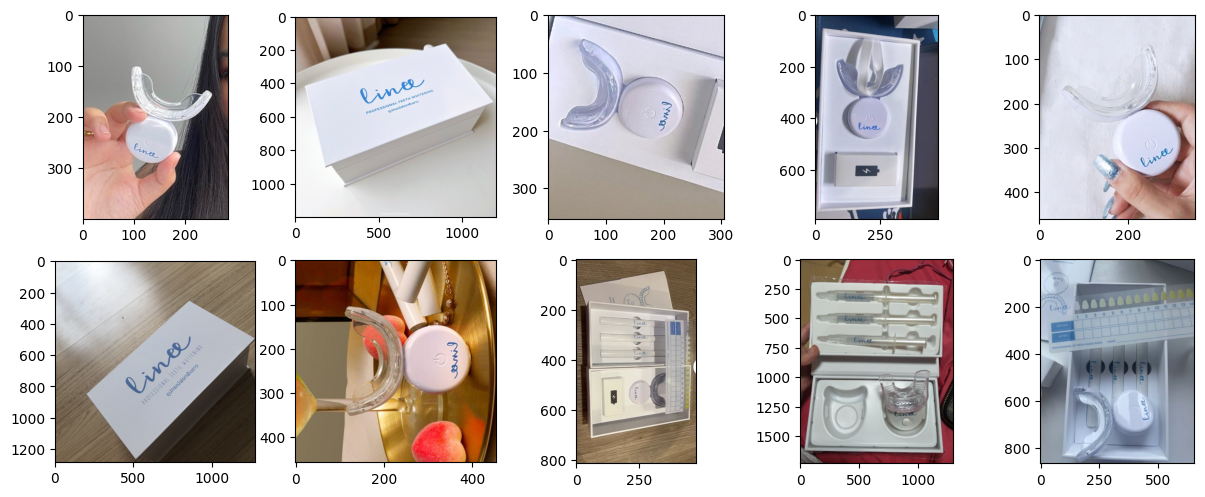

In [72]:
import matplotlib.pyplot as plt

def show_all_img_eid(eid, df=scan_df_clean, show_max=10, img_size=2.5, columns=5):
    img_path = df[df['labels'] == eid]['images_path'].values
    n_img = min(len(img_path), show_max)
    rows = n_img // columns + 1
    fig = plt.figure(figsize=(columns*img_size, rows*img_size,))
    for i in range(n_img):
        img = plt.imread(img_path[i])
        h, w, _ = img.shape
        if h < w:
            img = np.transpose(img, (1, 0, 2))
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
    plt.show()
    
show_all_img_eid(48437)

# Insert

In [15]:
def insert_data(body, tag_name):
    response = requests.post(
        url="http://localhost:4446/" + tag_name + "/insert", 
        json=body,
        headers={
            "Content-Type": "application/json", 
            'Authorization': 'Bearer dev'
            },
    )
    if response.status_code != 201:
        print(response.status_code)
        print(response.text)
        return False
    return response

In [11]:
brand_body = {
  "active": 'true',
  "brand_id": "",
  "brand_name": "",
  "description": "",
  "update_by": "music",
  "created_at": "2022-02-07 00:00:00",
}

for i in tqdm(range(len(brand_data))):
    brand_body['brand_id'] = int(brand_data.iloc[i]['BID'])
    brand_body['brand_name'] = brand_data.iloc[i]['BRAND_NAME']
    brand_body['active'] = brand_data.iloc[i]['ACTIVE']
    brand_body['created_at'] = brand_data.iloc[i]['TIMESTAMP_X']    
    if not insert_data(brand_body, 'brand'):
        print(f'index {i}')
        break

  0%|          | 0/1485 [00:00<?, ?it/s]

409
{"detail":"brand_id already exists."}
index 0


In [35]:
category_body = {
  "active": 'true',
  "category_id": "",
  "category_name": "",
  "description": "",
  "update_by": "music",
  "created_at": "2022-02-07 00:00:00"
}

for i in tqdm(range(len(category_data))):
    category_body['category_id'] = int(category_data.iloc[i]['CID'])
    category_body['category_name'] = category_data.iloc[i]['CATEGORY_NAME']
    category_body['active'] = category_data.iloc[i]['ACTIVE']
    category_body['created_at'] = category_data.iloc[i]['TIMESTAMP_X']
    if not insert_data(category_body, 'category'):
        print(f'index {i}')
        break

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
subcategory_body = {
  "active": 'true',
  "category_id": "",
  "description": "",
  "subcategory_id": "",
  "subcategory_name": "",
  "update_by": "music",
  "created_at": "2022-02-07 00:00:00"
}
for i in tqdm(range(len(subcategory_data))):
    subcategory_body['category_id'] = int(subcategory_data.iloc[i]['CID'])
    subcategory_body['subcategory_id'] = int(subcategory_data.iloc[i]['SCID'])
    subcategory_body['subcategory_name'] = subcategory_data.iloc[i]['SUBCATEGORY_NAME']
    subcategory_body['active'] = subcategory_data.iloc[i]['ACTIVE']
    subcategory_body['created_at'] = subcategory_data.iloc[i]['TIMESTAMP_X']
    if not insert_data(subcategory_body, 'subcategory'):
        print(f'index {i}')
        break

  0%|          | 0/131 [00:00<?, ?it/s]

In [18]:
product_body = {
  "product_id": "",
  "product_name": "",
  "brand_id": "",
  "subcategory_id": "",
  "active": 'true',
  "description": "",
  "update_by": "music",
  "created_at": "1970-01-01 00:00:00",
  "url": "https://www.google.com/",
  "url_preview_image": "https://www.google.com/"
}

for i in tqdm(range(len(product_data_linked))):
    data = product_data_linked.iloc[i]
    product_body['product_id'] = int(data['EID'])
    product_body['product_name'] = data['PRODUCT_NAME']
    product_body['brand_id'] = int(data['BID'])
    product_body['subcategory_id'] = int(data['SCID']) if not np.isnan(data['SCID']) else ""
    product_body['active'] = data['ACTIVE']
    product_body['created_at'] = data['TIMESTAMP_X'] if isinstance(data['TIMESTAMP_X'], str) else '1970-01-01 00:00:00'
    product_body['url'] = data['PRODUCT_URL']
    product_body['url_preview_image'] = data['PREVIEW_PICTURE'] if data['PREVIEW_PICTURE'] != oops_url and data['PREVIEW_PICTURE'] != url_404 else "http"
    if not insert_data(product_body, 'product'):
        print(f'index {i}')
        break

  0%|          | 0/31953 [00:00<?, ?it/s]

In [69]:
scan_body = {
  "active": 'true',
  "counter": '0',
  "directory_name": "",
  "image_path": "",
  "product_id": "",
  "update_by": "admin"
}

for i in tqdm(range(len(scan_df_clean))):
    scan_body['image_path'] = scan_df_clean['images_path'][i]
    scan_body['product_id'] = str(scan_df_clean['labels'][i])
    if not insert_data(scan_body, 'scan'):
        print(f'index {i}')
        break

  0%|                                        | 15/93677 [00:07<12:14:02,  2.13it/s]

404
{"detail":"Product is not exists."}
index 15


In [ ]:
scan_body = {
  "active": 'true',
  "counter": '0',
  "directory_name": "",
  "image_path": "",
  "product_id": "",
  "update_by": "admin"
}

scan_body['image_path'] = '/app/www/vhosts/cosmenet.in.th/httpdocs-scanner-extract-feature/n01491361_tiger_shark.JPEG'
scan_body['product_id'] = str(scan_df_clean['labels'][0])

if not insert_data(scan_body, 'main'):
    print(f'fail')

In [14]:
pred_body = {
  "brand_id": "",
  "category_id": "",
  "image_path": "/app/www/vhosts/cosmenet.in.th/httpdocs-scanner-extract-feature/n01491361_tiger_shark.JPEG",
  "page": 1,
  "size": 5,
  "subcategory_id": "",
  "update_by": ""
}

In [122]:
response = requests.post(
    url="http://10.148.0.50:4446/" + 'predict' + "/product", 
    json=pred_body,
    headers={"Content-Type": "application/json"},
)